# Ordenação automática

Este notebook tem por objetivo descobrir a ordem automaticamente entre um grupo de images para formar um panorama

In [1]:
from src.utils import image_utils
from src.utils import notebook_utils

from src.process import feature_extraction, automatic_ordering
import cv2
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
images = image_utils.load_raw_images("PanoramaWebDataset")
print("load sucess")

load sucess


In [3]:
print(len(images))

6


## Algoritmo

In [4]:
import random

indices = list(range(len(images)))
random.shuffle(indices)

# Get values as a list
names = list(images.keys())
values = list(images.values())

# Reorder both lists using the shuffled indices
names_shuffled = [names[i] for i in indices]
values_shuffled = [values[i] for i in indices]

In [5]:
images_unordered = values_shuffled

In [6]:
kp_descs = [feature_extraction.SIFT(img, nfeatures=1000) for img in images_unordered]

## Grafo

Vamos gerar um grafo onde cada nó é uma imagem e cada aresta a quantidade de matches

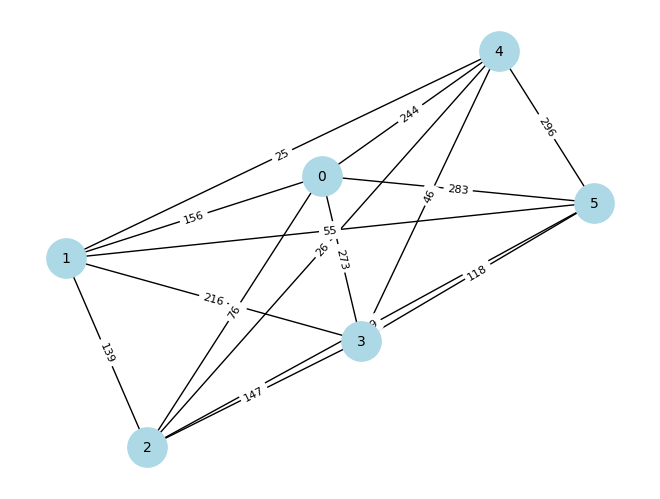

In [7]:
G, matches_per_image = automatic_ordering.build_match_graph(kp_descs, len(images))

# Draw the graph
pos = nx.spring_layout(G, seed=42)  # Layout for positioning
nx.draw(G, pos, with_labels=True, node_size=800, node_color="lightblue", font_size=10)

# Draw edge labels (weights)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

plt.show()

### Primeira ideia: arvore geradora mínima

In [8]:
mst = nx.minimum_spanning_tree(G, weight="weight", algorithm="kruskal")

print("Edges in MST:")
for u, v, w in mst.edges(data=True):
    print(f"{u} - {v} (weight {w['weight']})")

Edges in MST:
0 - 2 (weight 76)
1 - 4 (weight 25)
2 - 4 (weight 26)
2 - 5 (weight 29)
3 - 4 (weight 46)


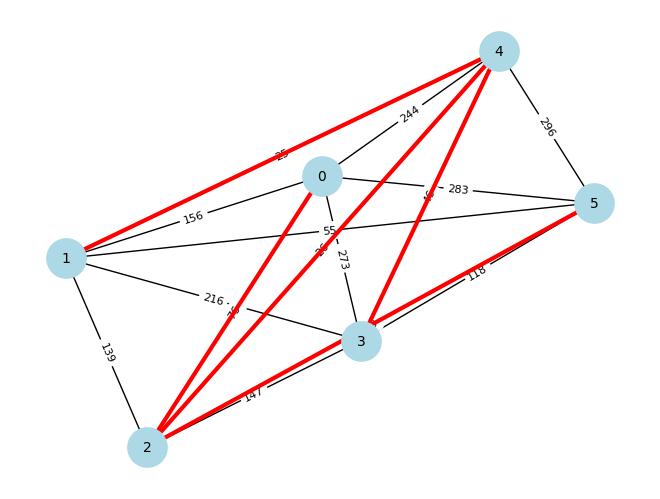

In [9]:
# Draw base graph
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=800, node_color="lightblue", font_size=10)

# Draw edge weights
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

# Highlight path
nx.draw_networkx_edges(G, pos,
                       edgelist=mst.edges,
                       edge_color="red",
                       width=3)

plt.show()

A árvore não necessariamente será um caminho, sendo assim, não é possível determinar qual imagem fica a direita de qual

### Ideia 2: caminho hamiltoniano

o caminho de custo mínimo. É um problema NP completo, mas como N (número de imagens) é assumido pequeno, podemos fazer um brute force, ou usar uma heurística.

O que estamos assumindo aqui é que **o panorama será a ordem das imagens onde mais terá matches entre imagens adjacentes**

In [10]:
path = automatic_ordering.hamiltonian_path_brute_force(G)
print("Hamiltonian path:", path)

Hamiltonian path: [2, 1, 3, 0, 5, 4]


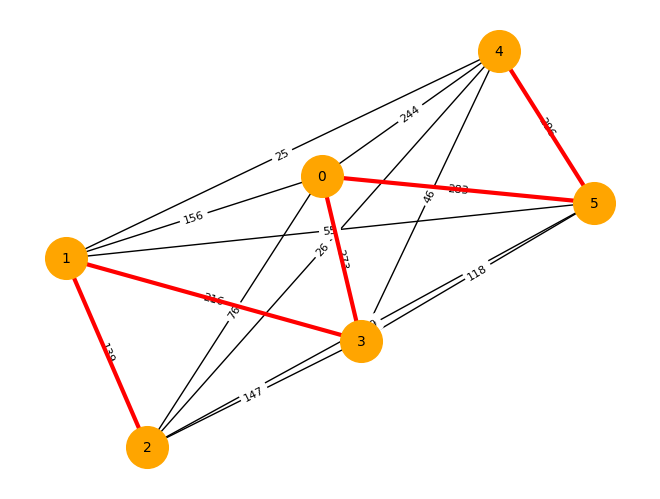

In [11]:
# Convert path into edge list
path_edges = list(zip(path[:-1], path[1:]))

# Draw base graph
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=800, node_color="lightblue", font_size=10)

# Draw edge weights
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

# Highlight path
nx.draw_networkx_edges(G, pos,
                       edgelist=path_edges,
                       edge_color="red",
                       width=3)

nx.draw_networkx_nodes(G, pos,
                       nodelist=path,
                       node_color="orange",
                       node_size=900)

plt.show()

In [12]:
unshuffled_names = [names_shuffled[i] for i in path]
unshuffled_names

['1', '2', '3', '4', '5', '6']

In [13]:
path = automatic_ordering.hamiltonian_path_heuristic(G)
print("Hamiltonian path (heuristic):", path)

Hamiltonian path (heuristic): [4, 5, 0, 3, 1, 2]


In [14]:
unshuffled_names = [names_shuffled[i] for i in path]
unshuffled_names

['6', '5', '4', '3', '2', '1']

In [15]:
names_shuffled

['4', '2', '1', '3', '6', '5']

Tanto o brute force como a heurística acharam o caminho correto. Porém, interessante notar que um achou o caminho ao contrário. Isso ocorre pq temos apenas informações da quantidade de matches entre as imagens, sendo impossível saber qual está a esquerda só com isso

### Achando a imagem a esquerda
Temos duas opções, que são as duas pontas do caminho hamiltoniano. Como escolher entre elas?

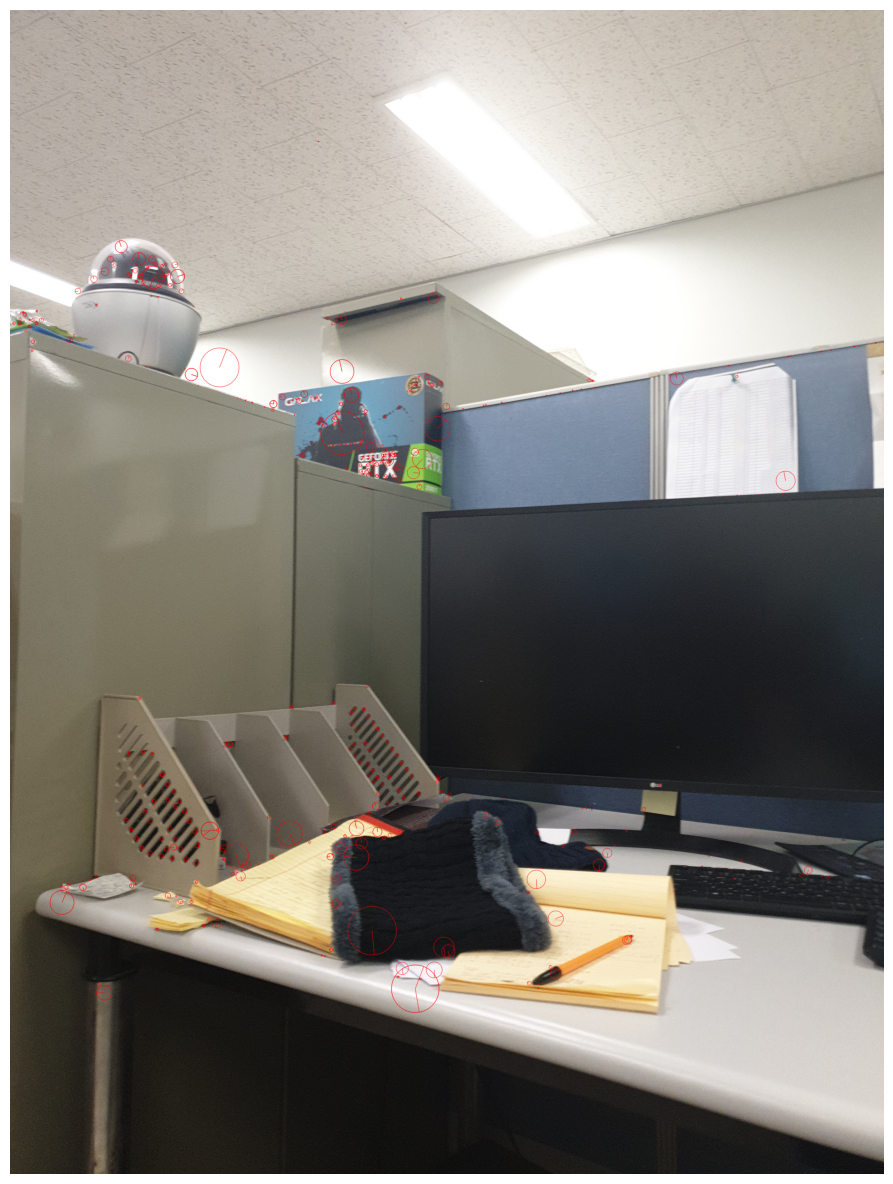

In [16]:
begin_path = path[0]

keypoints_match_begin = []
for match in matches_per_image[begin_path]:
    keypoints_match_begin.append(kp_descs[begin_path][0][match.queryIdx])
    
notebook_utils.show_image_with_keypoints(images_unordered[begin_path], keypoints_match_begin)

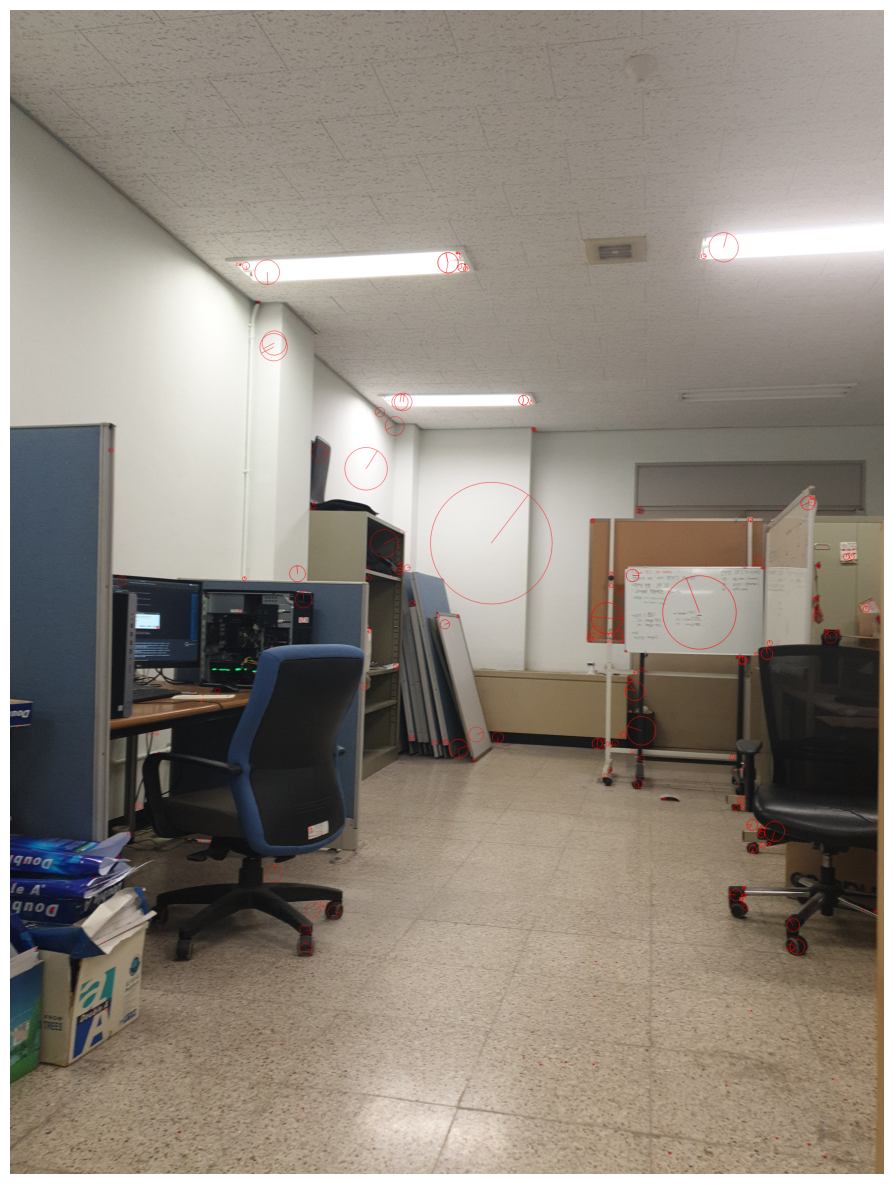

In [17]:
end_path = path[-1]

keypoints_match_end = []
for match in matches_per_image[end_path]:
    keypoints_match_end.append(kp_descs[end_path][0][match.queryIdx])
    
notebook_utils.show_image_with_keypoints(images_unordered[end_path], keypoints_match_end)

Vamos definir um valor chamado left_score, que representará o quão a "esquerda" os keypoints que deram match estão. Na imagem da esquerda do panorama de ordem correta, sua parte esquerda provavelmente não estará em nenhuma outra foto, logo seu left_score será menor.

In [18]:
width_image_begin = images_unordered[begin_path].shape[1]

left_score_begin = 0

for keypoint in keypoints_match_begin:
    left_score_begin += 1 - (keypoint.pt[0] / width_image_begin) # y coordinate

In [19]:
width_image_end = images_unordered[end_path].shape[1]

left_score_end = 0

for keypoint in keypoints_match_end:
    left_score_end += 1 - (keypoint.pt[0] / width_image_begin) # y coordinate

In [20]:
left_score_begin

420.25776070482533

In [21]:
left_score_end

193.54786077125996

A imagem com menor left score é a imagem a esquerda

In [22]:
width_image_begin

3024

## Método final

In [23]:
order = automatic_ordering.find_order(images_unordered)
order

[2, 1, 3, 0, 5, 4]

In [24]:
unshuffled_names = [names_shuffled[i] for i in order]
unshuffled_names

['1', '2', '3', '4', '5', '6']